# Seizing the Means of Tenserflow ☭
   
## Lab Seven: Wide and Deep Network Architectures
   
### Justin Ledford, Luke Wood, Traian Pop

In [1]:
%matplotlib inline
import numpy as np
import plotly
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
import requests

import warnings
warnings.filterwarnings('ignore')

## Dataset Selection

For this project, we chose the Census-Income-MLD dataset from the UCI Machine Learning Repository due to nature of the set being exactly what we needed. The set has both categorical and integer data, a large number of attributes (40), and a very large number of instances (approximately 300,000). Not only that, but the data is also very applicable and highly wanted in our society.
   
The dataset's goal is to be able to predict whether a person, based on the values of their attributes, is under or over the 50k income bar. However, our goal for this report is not simply just accuracy. We are placing much heavier emphasis on catching false negatives in the over 50k limit section. The reason for this choise falls under the logic of marketing and advertising. Since the census is public knowledge, advertising companies tend to use it to be able to predict their target market and where they are most likely to have an affect. 
   
One target for these companies are individuals who make more than the average amount for they have more money to spend. If an advertiser is given a list that is missing a good deal of >50k individuals, they are also missing out on potential profit. This is something that our report will prioritize in order for a situation like that to be avoided.


## Pre-Processing the Data

In [2]:
import pandas as pd
import numpy as np
import requests


# Get column names
r = requests.get('https://raw.githubusercontent.com/LukeWoodSMU/WillBeRenamed/master/col_names.txt')

if r.status_code == 200:
    columns = r.text.replace(" ","_").replace("'","").split('\n')[:-1]
else:
    print('Error loading column names')

In [3]:
print(columns)

['age', 'class_of_worker', 'industry_code', 'occupation_code', 'education', 'wage_per_hour', 'enrolled_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_status', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin', 'veterans_benefits', 'weeks_worked_in_year', 'year', 'income']

As you can see, there is a large number of attributes, with categories ranging anywhere from age to benefits. In order to ease the work on our program and receive better results, we will be crossing some of these attributes together.

First we preprocess the data by removing the "weight" column which is irrelevant for training our classifier. We also remove any instances that are missing any feature values.

In [4]:
df_train = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz',
        compression='gzip', header=None, index_col=False)


df_test = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.test.gz',
        compression='gzip', header=None, index_col=False)


# Remove weight columns
df_train.drop(24, 1, inplace=True)
df_test.drop(24, 1, inplace=True)

df_train.columns = columns
df_test.columns = columns

# Remove rows with missing data and reset index
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_train.head()


,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,income
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


In [5]:
# Wage per hour to categorical
df_train["wage_per_hour"] = df_train["wage_per_hour"].map(lambda i: i==0)

Next, we encode all of our categorical attributes with one-hot encoding, and scale all of our continuous attributes.

In [6]:
# Process data:

# check income values consistent (only 2 values)

# replace categorical with one hot encoding
# scale continuous

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

labels = dict() 

r = requests.get('https://raw.githubusercontent.com/LukeWoodSMU/WillBeRenamed/master/categorical.txt')
categorical_labels = r.text.replace(" ","_").replace("'","").split('\n')[:-1]

for col in categorical_labels + ['income']:
    # strip extra space in strings
    if df_train[col].dtype == 'object':
        df_train[col] = df_train[col].str.strip()
    if df_test[col].dtype == 'object':
        df_test[col] = df_test[col].str.strip()
        
    # convert to ints for one hot encoder to work
    
    # keep labels for reference 
    labels[col] = list(set(df_train[col].unique()) | set(df_test[col].unique()))
    
    df_train[col].replace(to_replace=labels[col],
                            value=np.arange(len(labels[col])),
                            inplace=True)
    df_test[col].replace(to_replace=labels[col],
                            value=np.arange(len(labels[col])),
                            inplace=True)

categorical_labels

['class_of_worker',
 'industry_code',
 'occupation_code',
 'education',
 'enrolled_in_edu_inst_last_wk',
 'marital_status',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'hispanic_origin',
 'sex',
 'member_of_a_labor_union',
 'reason_for_unemployment',
 'full_or_part_time_employment_stat',
 'tax_filer_status',
 'region_of_previous_residence',
 'state_of_previous_residence',
 'detailed_household_and_family_stat',
 'detailed_household_summary_in_household',
 'migration_code-change_in_msa',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg',
 'live_in_this_house_1_year_ago',
 'migration_prev_res_in_sunbelt',
 'family_members_under_18',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed',
 'fill_inc_questionnaire_for_veterans_admin',
 'veterans_benefits',
 'year',
 'wage_per_hour']

In [7]:
r = requests.get('https://raw.githubusercontent.com/LukeWoodSMU/WillBeRenamed/master/continuous.txt')
continuous_labels = r.text.replace(" ","_").replace("'","").split('\n')[:-1]


for col in continuous_labels:
    df_train[col] = df_train[col].astype(np.float32)
    df_test[col] = df_test[col].astype(np.float32)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
continuous_labels

['age',
 'capital_gains',
 'capital_losses',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

Most of our classes are categorical, with only 6 of them being continuous. Right away we can see that the year (1994 or 1995) the data was collected is irrelevant so we will drop that one. Most of the remaining features don't seem immediately irrelevant so in order to determine which features we can drop we run a chi-squared test to estimate the correlation of each feature to our target class.

In [8]:
def expected_data(observed):
    expected = np.zeros(observed.shape)

    total = observed.sum().sum()
    for j in [0, 1]:
        for i, col_total in enumerate(observed.sum()):
            row_total = observed.sum(axis=1)[j]
            expected[j][i] = row_total*col_total/total

    return pd.DataFrame(expected, index=observed.index,
                        columns=observed.columns)

In [9]:
df_freq = df_train.copy()
def attr_freqs(attr1, attr2):
    return pd.crosstab(df_freq[attr2], df_freq[attr1], rownames=[attr2], colnames=[attr1])

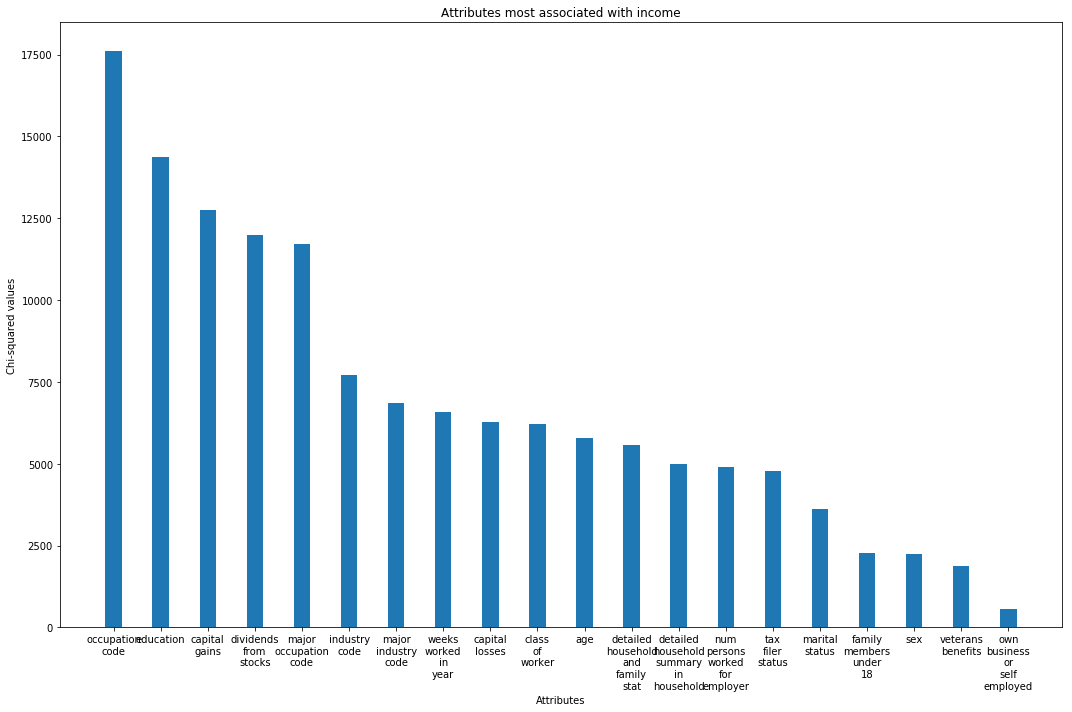

In [10]:
chisqrs = []

for colname in df_freq.columns:
    if colname != 'income':
        observed = attr_freqs(colname, 'income')
        expected = expected_data(observed)
        chisqr = (((observed-expected)**2)/expected).sum().sum()
        chisqrs.append((chisqr, colname))

chisqrs = sorted(chisqrs)[::-1]
chisqrs_top = chisqrs[:20]
values = [d[0] for d in chisqrs_top]
chi_labels = [d[1].replace("_", "\n") for d in chisqrs_top]

index = np.arange(len(chisqrs_top))
bar_width = .35
opacity=0.4

plt.figure(figsize=(15, 10))
plt.title("Attributes most associated with income")
plt.bar(index, values, bar_width, align='center')
plt.xticks(index, chi_labels)
plt.ylabel("Chi-squared values")
plt.xlabel("Attributes")
plt.autoscale()
plt.tight_layout()
plt.show()

From the results of our chi squared test we estimate that occupation is one of the most important features, along with education, capital gains and dividends from stocks. This makes sense given that certain jobs tend to pay more, and a higher education lvel is usually needed to attain these jobs. It also makes sense that capital gains and dividends from stocks would be highly correlated with income because in general wealthier people have more money to make investments.

In [11]:
drop_labels = [c[1] for c in chisqrs[-20:]]
print(drop_labels)

['country_of_birth_father', 'member_of_a_labor_union', 'country_of_birth_mother', 'hispanic_origin', 'enrolled_in_edu_inst_last_wk', 'race', 'country_of_birth_self', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago', 'state_of_previous_residence', 'region_of_previous_residence', 'citizenship', 'migration_prev_res_in_sunbelt', 'reason_for_unemployment', 'fill_inc_questionnaire_for_veterans_admin', 'wage_per_hour', 'year', 'full_or_part_time_employment_stat']


Next we check how many instances are in each class to see if we need to do any balancing.

In [12]:
df_train.drop(drop_labels, axis=1, inplace=True)
df_test.drop(drop_labels, axis=1, inplace=True)

categorical_labels = [label for label in categorical_labels if label not in drop_labels]
continuous_labels = [label for label in continuous_labels if label not in drop_labels]

In order to make our data set smaller and still keep our accuracy, we decided to remove the bottom 20 attributes due to their low correlation with the income class. Our data set was significantly reduced (almost by half), but we felt it was justified due to the minimal impact those attributes had on our classification. We were then able to run the data faster and more often.

### Balancing the Dataset

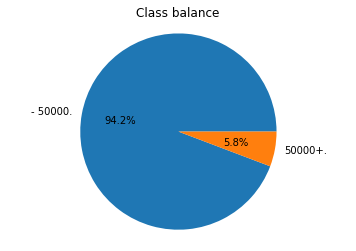

In [13]:
import matplotlib.pyplot as plt

sizes = np.bincount(df_train['income'].values)

plt.pie(sizes, labels=labels['income'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Class balance')
plt.show()

From the chart we can see that there is a very high class imbalance. In order to deal with this we will oversample the 50000+ class and undersample the -50000 class.

In [14]:
# over sample class

df_ = df_train.copy().reset_index(drop=True)

total_size = df_.shape[0]
below50k_indices = df_[df_['income'] == 0].index
above50k_indices = df_[df_['income'] == 1].index

below50k_indices_sample = np.random.choice(below50k_indices, total_size // 2)
above50k_indices_sample = np.random.choice(above50k_indices, total_size // 2)

df_sampled = pd.concat([df_.iloc[below50k_indices_sample], df_.iloc[above50k_indices_sample]])
df_sampled = df_sampled.reset_index(drop=True)

Now we have a balanced dataset.

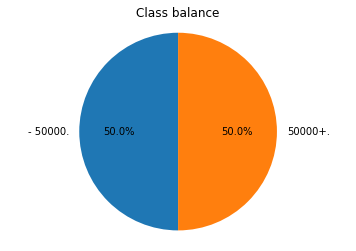

In [15]:
sizes = np.bincount(df_sampled['income'].values)

plt.pie(sizes, labels=labels['income'], startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Class balance')
plt.show()

### Crossing Attributes

In [30]:
cross_columns_initial = [('education','occupation_code')]

TODO: Write about features combining

### Scoring our Results

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

As mentioned above, we are evaluating our model on how well we can classify the >50k class and avoid false negatives. We do this by scoring our model with a recall score.

### Splitting the Data

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5)

For our cross validation method we decided to train on the balanced set, and then test using an set with the original class balance. Instead of using the sklearn stratified shuffle split we will use the pandas sample method to get a stratified sample of each data frame. We chose to do this so that we can split our test set and train set separately. We also chose to do a shuffle split instead of stratified k-folds due to how large our dataset is and stratified shuffle split is a bit faster than k-folds. It is also the recommended method by the source where we received our data from.
___

## Modeling

### Creating a wide and deep network using tensorflow

Now create a wide and deep neural network using Tensorflow. First we have to create some helper functions to process the data for TF's classifiers.

In [18]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
tf.logging.set_verbosity(tf.logging.ERROR) # control the verbosity of tensor flow

In [19]:
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input_cc(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    continuous_cols = {k: tf.reshape(tf.constant(df[k].values), [-1]) for k in numeric_headers}
      
    # tensors to be sparse one-hot encoded values
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
                              indices=[[i, 0] for i in range(df[k].size)],
                              values=df[k].astype(str).values,
                              dense_shape=[df[k].size, 1])
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(categorical_cols)
    feature_cols.update(continuous_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label

Now we create a function to set up the wide and deep columns that will accept a list of columns to cross so we can experiment with different combinations.

In [20]:
# update the model to take input features as a dictionary
def setup_wide_deep_columns(cross_columns):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []    
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_labels:
        wide_columns.append(
            layers.sparse_column_with_keys(col, keys=[str(x) for x in labels[col]])
        )
        
        dim = round(np.log2(len(labels[col]))) + 1
        deep_columns.append(
            layers.embedding_column(wide_columns[-1], dimension=dim)
        )
        
    # also add in some specific crossed columns
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=[str(x) for x in labels[tup[0]]]),
                 layers.sparse_column_with_keys(tup[1], keys=[str(x) for x in labels[tup[1]]])],
            hash_bucket_size=int(1e4))
        )
        
        
    # and add in the regular dense features 
    for col in continuous_labels:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return wide_columns, deep_columns

### Comparing different architectures

In [98]:
%%time

# Compare different archs

df = df_sampled.sample(frac=0.01)
#df = df_train.sample(frac=0.01)
#df = df_sampled.copy()

wide_columns, deep_columns = setup_wide_deep_columns(cross_columns_initial)

n_splits = 5 

dnn1_scores = []
dnn2_scores = []

# Stratified shuffle split where training set is balanced, test set unbalanced
for i in range(0, n_splits):
    df_train_sample = df.sample(frac=1/n_splits)
    df_test_sample = df_test.sample(frac=0.01)
   
    dnn1 = learn.DNNLinearCombinedClassifier(
                            linear_feature_columns=wide_columns,
                            dnn_feature_columns=deep_columns,
                            dnn_hidden_units=[1000, 500])
    
    dnn2 = learn.DNNLinearCombinedClassifier(
                            linear_feature_columns=wide_columns,
                            dnn_feature_columns=deep_columns,
                            dnn_hidden_units=[50, 50, 50, 50])   

    input_wrapper = lambda:process_input_cc(df_train_sample,'income',categorical_labels, continuous_labels)
    output_wrapper = lambda:process_input_cc(df_test_sample,None,categorical_labels, continuous_labels)
    
    y_test = df_test_sample['income']

    dnn1.fit(input_fn=input_wrapper, steps=500)
    yhat_dnn1 = list(dnn1.predict(input_fn=output_wrapper))
    print('DNN1')
    print(confusion_matrix(y_test,yhat_dnn1),
          recall_score(y_test,yhat_dnn1))
    
    
    dnn2.fit(input_fn=input_wrapper, steps=500)
    yhat_dnn2 = list(dnn2.predict(input_fn=output_wrapper))
    print('DNN2')
    print(confusion_matrix(y_test,yhat_dnn2),
          recall_score(y_test,yhat_dnn2))
    
    
    dnn1_scores.append(recall_score(y_test,yhat_dnn1))
    dnn2_scores.append(recall_score(y_test,yhat_dnn2))

DNN1
[[ 18   4]
 [ 92 360]] 0.796460176991
DNN2
[[ 19   3]
 [123 329]] 0.727876106195
DNN1
[[ 21   2]
 [ 81 370]] 0.820399113082
DNN2
[[ 20   3]
 [ 66 385]] 0.853658536585
DNN1
[[ 22   4]
 [ 97 351]] 0.783482142857


KeyboardInterrupt: 

In [25]:
print('DNN1 average: {}'.format(np.average(dnn1_scores)))
print('DNN2 average: {}'.format(np.average(dnn2_scores)))

DNN1 average: 0.8571428571428571
DNN2 average: 0.8588235294117649


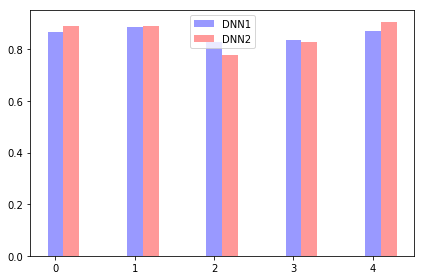

In [26]:
bar_width = 0.20
index = np.arange(n_splits)
opacity=0.4

plt.bar(index, dnn1_scores, bar_width, align='center',
        color='b', label='DNN1', alpha=opacity)
plt.bar(index + bar_width, dnn2_scores, bar_width,
        align='center', color='r', label='DNN2', alpha=opacity)

plt.legend()
plt.tight_layout()
plt.show()

### Comparison with MLP

In [ ]:
%%time

from sklearn.neural_network import MLPClassifier
from numpy import interp

tf.logging.set_verbosity(tf.logging.ERROR)

# use entire dataset if training on maneframe
df = df_sampled.sample(frac=0.01)
#df = df_sampled.copy()

wide_columns, deep_columns = setup_wide_deep_columns(cross_columns_initial)

mlp_roc_auc = []
dnn_roc_auc = []

mean_tpr_mlp = 0.0
mean_fpr_mlp = np.linspace(0, 1, 100)
mean_tpr_dnn = 0.0
mean_fpr_dnn = np.linspace(0, 1, 100)

n_splits = 5

for i in range(0, n_splits):
    df_train_sample = df.sample(frac=1/n_splits)
    df_test_sample = df_test.sample(frac=0.01)
    
    X_train = df_train_sample.drop('income', axis=1)
    y_train = df_train_sample['income']

    X_test = df_test_sample.drop('income', axis=1)
    y_test = df_test_sample['income']
 
    
    dnn = learn.DNNLinearCombinedClassifier(
                            linear_feature_columns=wide_columns,
                            dnn_feature_columns=deep_columns,
                            dnn_hidden_units=[100, 50, 25, 5])
    
    mlp = MLPClassifier()
    
    
    
    input_wrapper = lambda:process_input_cc(df_train_sample,'income',categorical_labels, continuous_labels)
    output_wrapper = lambda:process_input_cc(df_test_sample,None,categorical_labels, continuous_labels)
    
    
    dnn.fit(input_fn=input_wrapper, steps=500)
    mlp.fit(X_train, y_train)

    yhat_dnn = list(dnn.predict(input_fn=output_wrapper))
    yhat_mlp = mlp.predict(X_test)

    print('DNN')
    print(confusion_matrix(y_test,yhat_dnn),
          recall_score(y_test,yhat_dnn))
    
    print('MLP')
    print(confusion_matrix(y_test,yhat_mlp),
          recall_score(y_test,yhat_mlp))
    
    probs_dnn = list(dnn.predict_proba(input_fn=output_wrapper))
    probs_dnn = np.array(probs_dnn)[:,1]
    fpr_dnn, tpr_dnn, _ = roc_curve(y_test, probs_dnn)
    dnn_roc_auc.append((fpr_dnn, tpr_dnn, auc(fpr_dnn, tpr_dnn)))
    mean_tpr_dnn += interp(mean_fpr_dnn, fpr_dnn, tpr_dnn)
    mean_tpr_dnn[0] = 0.0   
    
    probs_mlp = mlp.predict_proba(X_test)
    probs_mlp = np.array(probs_mlp)[:,1]
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, probs_mlp)
    mlp_roc_auc.append((fpr_mlp, tpr_mlp, auc(fpr_mlp, tpr_mlp)))
    mean_tpr_mlp  += interp(mean_fpr_mlp, fpr_mlp, tpr_mlp)
    mean_tpr_mlp [0] = 0.0

In [28]:
mean_tpr_mlp /= n_splits
mean_tpr_mlp[-1] = 1.0
mean_auc_mlp = auc(mean_fpr_mlp, mean_tpr_mlp)

mean_tpr_dnn /= n_splits
mean_tpr_dnn[-1] = 1.0
mean_auc_dnn = auc(mean_fpr_dnn, mean_tpr_dnn)

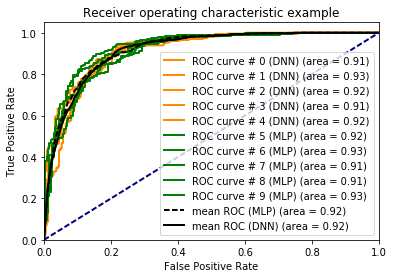

In [29]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
i = 0
for fpr, tpr, auc_ in dnn_roc_auc:
        plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve # %d (DNN) (area = %0.2f)' % (i, auc_))
        i += 1
for fpr, tpr, auc_ in mlp_roc_auc:
        plt.plot(fpr, tpr, color='green',
             lw=lw, label='ROC curve # %d (MLP) (area = %0.2f)' % (i, auc_))
        i += 1        
        
plt.plot(mean_fpr_mlp, mean_tpr_mlp, 'k--', label='mean ROC (MLP) (area = %0.2f)' % mean_auc_mlp, lw=2)
plt.plot(mean_fpr_dnn, mean_tpr_dnn, 'k-', label='mean ROC (DNN) (area = %0.2f)' % mean_auc_dnn, lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

When comparing our network with SKLearning MLP, we notice that even though the averages are the same, the ROC curve for the DNN is more stable throughout than the ROC curve for the MLP. 

___

## Exceptional Work (10 points total)
   
### One idea: Investigate which cross-product features are most important and hypothesize why.
___

### Cross-Product Features
We have decided to analyze and theorize which cross-product features will help the model learn to classify people into the >50k and \<50k income brackets.

To begin, we first examined the attributes sex and age.  We believed that these would have a higher correlation with income than what was appearing in the chi-square graph.  We thought that it was possible that the network could learn quite a bit by combining these and recognizing that a woman between 20 and 30 is likely to take a leave from work or that a male/female above 65 will be likely to have retired.  

We also thought that by pairing capital gains and capital losses we could learn quite a bit about the overall income of the individual so we paired those together as well.

Finally, we also thought that dividends along with information about the occupation/industry the individual is in would be relevant in determining the level of position the individual is in, so we also included those cross pairs.  Below is a comparison of the performance of these various cross product sets.

In [ ]:
cross_product_feature_sets = [
    [("sex","age")],
    [("capital_gains","occupation_code")],
    [("captial_gains","capital_losses")]
]

for cross_product_set in cross_product_feature_sets:
    print(cross_product_set)